# Advanced Driver Comfort Analysis
*BeamNG.tech only*

## Introduction

This example will demonstrate how to use the tri-axial IMU sensor to do a simple analysis for driver comfort while driving. An IMU contains a tri-axial accelerometer; a sensor that measures linear acceleration in the local coordinate system of the sensor. BeamNGpy provides a simulated version of such a sensor that can be placed in or on the vehicle, or at a point in space relative to the vehicle (as if it was attached to the vehicle by some rigid rod, even although this would be invisible). The readings from the IMU are smoothed against previous readings in order to remove some high-frequency noise from the data. Contrary to real accelerometer data, BeamNG's are completely size and weightless, meaning they have no effect on the behaviour of the vehicle and an arbitrary amount of them can be added.

## Scenario 

Our scenario contains two vehicles that are tasked with driving to a certain waypoint on the map using BeamNG's AI. The AI will be given different speed levels and aggression values. Both vehicles are equipped with an IMU placed at the headrest of the driver's seat, providing regular acceleration measurements over a time interval. After both vehicles arrive at their destination, the data measured for both will be plotted for comparison.

## Setup

Setting up the environment starts with importing the required classes, mainly:

* `BeamNGpy`: The backbone of the library used to manage BeamNG and communicate with the running simulation
* `Scenario`: A class representing the scenario we set up. It will contain information about which level to load and vehicles contained in the scenario.
* `Vehicle`: Each of our vehicles will be an instance of this class. It is used to represent and communicate with a vehicle in the simulation.
* `AdvancedIMU`: The class implementing an advanced IMU sensor (the focus of this example). Each vehicle will have an instance of this to gather measurements.

Instances of these classes are compiled into one scenario that will then be loaded in the simulator.

Additionally, some modules and classes related to later plotting are imported.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from time import sleep
from beamngpy import BeamNGpy, Scenario, Vehicle
from beamngpy.sensors import AdvancedIMU

sns.set()  # Let seaborn apply better styling to all matplotlib graphs

The actual scenario will be set up by instantiating the `Scenario` class with an instance set on `west_coast_usa` that we name "driver_comfort". Two instances of the `Vehicle` class will be created using the ETK800 model and given unique names for later reference.

In [2]:
beamng = BeamNGpy('localhost', 64256)
beamng.open()

scenario = Scenario('west_coast_usa', 'driver_comfort')

careful = Vehicle('careful', model='etk800', license='CAREFUL', color='Green')
aggressive = Vehicle('aggressive', model='etk800', license='AGGRO', color='Red')

We add the vehicles to our scenario and start the scenario. The locations they are placed were determined manually in the game's World Editor. The call to `scenario.make(beamng)` creates files necessary for the game to load our scenario during the simulation.

In [3]:
scenario.add_vehicle(careful, pos=(-767.1, 402.8, 142.8), rot_quat=(0, 0, 0.027, 1))
scenario.add_vehicle(aggressive, pos=(-770.1, 398.8, 142.8), rot_quat=(0, 0, 0.027, 1))

scenario.make(beamng)
beamng.scenario.load(scenario)
beamng.settings.set_deterministic()
beamng.settings.set_steps_per_second(60)
beamng.scenario.start()

With two vehicles instantiated we move on to creating IMU sensor objects. These objects are placed at locations *relative to the vehicle's origin* (or, vehicle space). This means an IMU placed at (0, 0, 0) is always at the vehicle's origin, regardless of its position in the world. Note that this is not exactly the center of mass of the vehicle. Accurate placement of the IMU can be done by looking at node positions in the game's vehicle editor to get reference values. For the creation of this example, the game was started manually and the location for IMUs was determined by looking at relative node positions close to the driver's headrest of the ETK800 vehicle.

In [4]:
careful_accel = AdvancedIMU('careful_sensor', beamng, careful, pos=(0.73, 0.51, 0.8))
aggressive_accel = AdvancedIMU('aggressive_sensor', beamng, aggressive, pos=(0.73, 0.51, 0.8))

We further set up some lists which will contain dimension-wise measurement data for both vehicles. We also store the time-stamps.

In [5]:
careful_data_x = []
careful_data_y = []
careful_data_z = []
careful_data_t = []
aggressive_data_x = []
aggressive_data_y = []
aggressive_data_z = []
aggressive_data_t = []

## Running

After our scenario is loaded in the simulator, we start the scenario letting the aggressive vehicle drive to its destination first, using a high maximum speed and high aggression value. Afterwards, the careful vehicle is given the same destination but a lower speed limit and lower aggression value.

In [6]:
aggressive.switch()  # Switches the game's focus to the aggressive vehicle. No effect besides making it easier to watch.

aggressive.ai.set_waypoint('junction1_wp24')
aggressive.ai.set_speed(50, mode='limit')
aggressive.ai.set_aggression(1)
sleep(5)  # A little pause before we start

for t in range(0, 2000):
    accel_data = aggressive_accel.poll()
    for i in range(0, len(accel_data)):
        aggressive_data_x.append(accel_data[i]['accSmooth'][0])                 # The reading in the IMU's local x-axis.
        aggressive_data_y.append(accel_data[i]['accSmooth'][1])                 # The reading in the IMU's local y-axis.
        aggressive_data_z.append(accel_data[i]['accSmooth'][2])                 # The reading in the IMU's local z-axis.
        aggressive_data_t.append(accel_data[i]['time'])                         # The time stamp for this tri-axial reading.

aggressive.ai.set_waypoint('tunnel_NE_A_1')  # Make it move away to make room for the careful car

careful.switch()  # Switches the game's focus to the careful vehicle. No effect besides making it easier to watch.

careful.ai.set_waypoint('junction1_wp24')
careful.ai.set_speed(10, mode='limit')
careful.ai.set_aggression(0.3)
sleep(5)  # A little pause before we start

for t in range(0, 2000):
    accel_data = careful_accel.poll()
    for i in range(0, len(accel_data)):
        careful_data_x.append(accel_data[i]['accSmooth'][0])                 # The reading in the IMU's local x-axis.
        careful_data_y.append(accel_data[i]['accSmooth'][1])                 # The reading in the IMU's local y-axis.
        careful_data_z.append(accel_data[i]['accSmooth'][2])                 # The reading in the IMU's local z-axis.
        careful_data_t.append(accel_data[i]['time'])                         # The time stamp for this tri-axial reading.

careful_accel.remove()      # remove the IMU sensors from the vehicles.
aggressive_accel.remove()
beamng.close()              # Close beamng as all data was gathered

## Plotting

The acceleration data is now plotted above and below, for an easy comparison between the two vehicles. The top row of plots contain the linear acceleration measured for the aggresively-driven vehicle, for each local axis of the accelerometers coordinate system.  The bottom row of plots show the same for the carefully-driven vehicle.

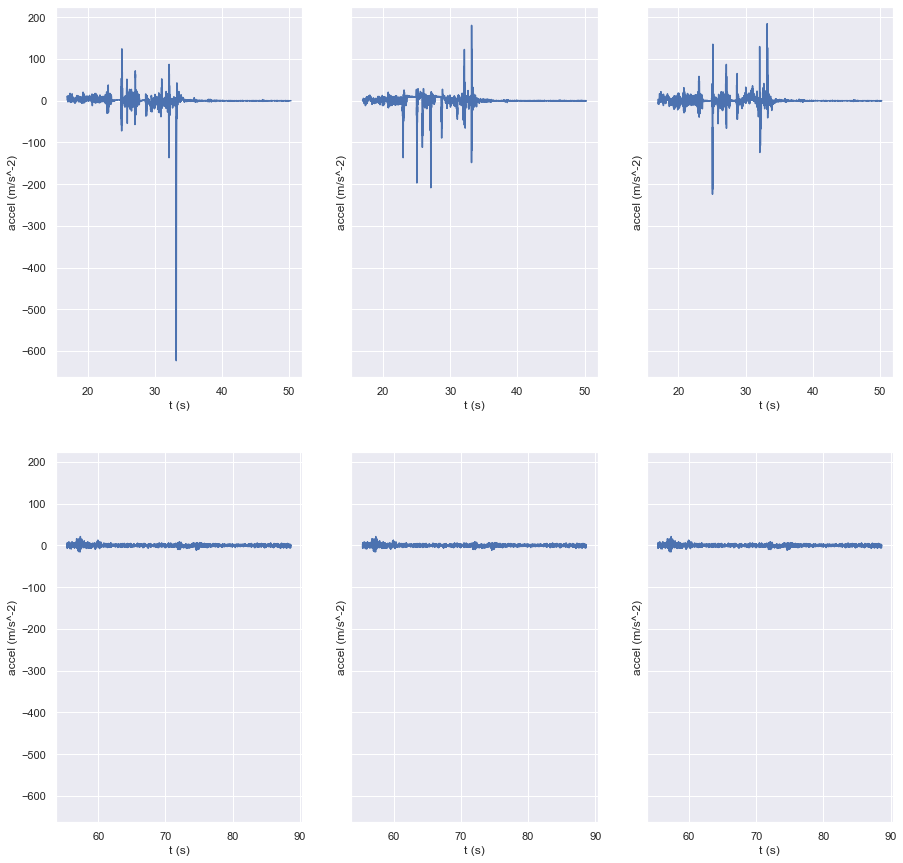

In [7]:
figure, ax = plt.subplots(2, 3, figsize=(15, 15), sharey=True)
ax[0, 0].plot(aggressive_data_t, aggressive_data_x, 'b-')
ax[0, 0].set_xlabel('t (s)')
ax[0, 0].set_ylabel('accel (m/s^-2)')
ax[0, 1].plot(aggressive_data_t, aggressive_data_y, 'b-')
ax[0, 1].set_xlabel('t (s)')
ax[0, 1].set_ylabel('accel (m/s^-2)')
ax[0, 2].plot(aggressive_data_t, aggressive_data_z, 'b-')
ax[0, 2].set_xlabel('t (s)')
ax[0, 2].set_ylabel('accel (m/s^-2)')
ax[1, 0].plot(careful_data_t, careful_data_x, 'b-')
ax[1, 0].set_xlabel('t (s)')
ax[1, 0].set_ylabel('accel (m/s^-2)')
ax[1, 1].plot(careful_data_t, careful_data_x, 'b-')
ax[1, 1].set_xlabel('t (s)')
ax[1, 1].set_ylabel('accel (m/s^-2)')
ax[1, 2].plot(careful_data_t, careful_data_x, 'b-')
ax[1, 2].set_xlabel('t (s)')
ax[1, 2].set_ylabel('accel (m/s^-2)')
plt.show()